In [85]:
MODELS_FROM_FILE = 0
IMPORTANCES_FROM_FILE = 0

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import ElasticNet

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, balanced_accuracy_score, f1_score, roc_auc_score, fbeta_score, make_scorer, roc_curve, precision_recall_curve, accuracy_score, r2_score
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

    
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', None)


data_intermediate_dir = "data/intermediate/"
item_lvl_wo_imp = pd.read_csv(data_intermediate_dir + "item_lvl_wo_impairment.csv")

# Prepare input and ouptut column names

output_cols = [x for x in item_lvl_wo_imp.columns if x.startswith("WHODAS") or x.startswith("CIS")] # All impairment columns

input_cols = [x for x in item_lvl_wo_imp.columns if 
                       not x.startswith("Diag: ") 
                       and not x.startswith("WIAT")
                       and not x.startswith("WISC")
                       and not x.startswith("WHODAS")
                       and not x.startswith("CIS")] # Input columns are all columns except Diagnosis, WIAT, and WISC, impairment columns

# Separate test set for all impairment scores

# Shuffle the dataset 
shuffle_df = item_lvl_wo_imp.sample(frac=1, random_state=42)

# Define a size for the train set 
train_size = int(0.7 * len(item_lvl_wo_imp))

# Split the dataset 
train_set = shuffle_df[:train_size]
test_set = shuffle_df[train_size:] # Don't touch this until the end

# Train_train and Validation set
# Define a size for your train_train set 
train_train_size = int(0.7 * len(train_set))

# Split your dataset 
train_train_set = train_set[:train_train_size]
val_set = train_set[train_train_size:]

In [86]:
def get_base_models_and_param_grids():
    
    # Define base models
    dt = DecisionTreeRegressor()
    rf = RandomForestRegressor()
    svr = svm.SVR()
    en = ElasticNet()
    
    # Impute missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    # Standardize data
    scaler = StandardScaler()

    # Make pipelines
    dt_pipe = make_pipeline(imputer, scaler, dt)
    rf_pipe = make_pipeline(imputer, scaler, rf)
    svr_pipe = make_pipeline(imputer, scaler, svr)
    en_pipe = make_pipeline(imputer, scaler, en)
    
    # Define parameter grids to search for each pipe
    from scipy.stats import loguniform, uniform
    dt_param_grid = {
        "decisiontreeregressor__splitter": ["best","random"],
        "decisiontreeregressor__min_samples_split": np.random.randint(2, 20, 30),
        "decisiontreeregressor__max_depth": np.random.randint(1, 30, 30),
        "decisiontreeregressor__min_samples_leaf": np.random.randint(1, 20, 30),
        "decisiontreeregressor__max_leaf_nodes": np.random.randint(2, 50, 30)
    }
    rf_param_grid = {
        'randomforestregressor__max_depth' : np.random.randint(5, 150, 30),
        'randomforestregressor__min_samples_split': np.random.randint(2, 50, 30),
        'randomforestregressor__n_estimators': np.random.randint(50, 400, 10),
        'randomforestregressor__min_samples_leaf': np.random.randint(1, 20, 30),
        'randomforestregressor__max_features': ['auto', 'sqrt', 'log2', 0.25, 0.5, 0.75, 1.0]
    }
    svr_param_grid = {
        'svr__C': loguniform(1e-03, 1e+02),
        'svr__gamma': loguniform(1e-03, 1e+02),
        'svr__degree': uniform(2, 5),
        'svr__epsilon': loguniform(1e-03,1),
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    en_param_grid = {
        'elasticnet__alpha': loguniform(1e-5, 100),
        'elasticnet__l1_ratio': uniform(0, 1)
    }
    
    base_models_and_param_grids = [
        (dt_pipe, dt_param_grid),
        (rf_pipe, rf_param_grid),
        (svr_pipe, svr_param_grid),
        (en_pipe, en_param_grid),
    ]
    
    return base_models_and_param_grids

def get_best_classifier(base_model, grid, output_col):
    rs = RandomizedSearchCV(estimator=base_model, param_distributions=grid, cv=3, scoring="r2", n_iter=100, n_jobs = -1)
    
    rs.fit(train_set[input_cols], train_set[output_col]) # On train_set, not train_train_set because do cross-validation
    
    best_estimator = rs.best_estimator_
    best_score = rs.best_score_
    
    return (best_estimator, best_score)

In [87]:
def find_best_estimator_for_output(output_col):
    best_score = 0
    best_classifier = None
    base_models_and_param_grids = get_base_models_and_param_grids()
    for (base_model, grid) in base_models_and_param_grids:
        best_classifier_for_model, best_score_for_model = get_best_classifier(base_model, grid, output_col)
        if best_score_for_model > best_score:
            best_classifier = best_classifier_for_model
            best_score = best_score_for_model
    return best_classifier

In [88]:
if MODELS_FROM_FILE == 0:
    best_estimators = {}
    for output in output_cols:
        best_estimator_for_output = find_best_estimator_for_output(output)
        best_estimators[output] = best_estimator_for_output
        print("Best estimator for ", output, ": ", best_estimators[output])

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.942e+03, tolerance: 1.750e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e+03, tolerance: 1.867e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.765e+03, tolerance: 1.821e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e+03, tolerance: 1.750e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.657e+02, tolerance: 1.821e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.899e+01, tolerance: 1.750e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e+03, tolerance: 1.867e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e+03, tolerance: 1.821e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.703e+03, tolerance: 1.821e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e+01, tolerance: 1.750e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.545e+01, tolerance: 1.750e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.815e+03, tolerance: 1.750e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  WHODAS_P,WHODAS_P_Total :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=1.148725569192509,
                            l1_ratio=0.3079941431109804))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e+01, tolerance: 6.506e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.213e+02, tolerance: 6.506e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.882e+02, tolerance: 6.506e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e+02, tolerance: 6.446e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.765e+02, tolerance: 6.446e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.947e+02, tolerance: 6.493e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.937e+02, tolerance: 6.506e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.765e+02, tolerance: 6.506e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.069e+02, tolerance: 6.506e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.715e+02, tolerance: 6.446e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  CIS_P,CIS_P_Score :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.5992236680568075,
                            l1_ratio=0.2617925353694197))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.054e+04, tolerance: 2.250e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.839e+03, tolerance: 2.098e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.218e+03, tolerance: 2.250e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.413e+03, tolerance: 2.098e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.065e+03, tolerance: 2.250e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.267e+03, tolerance: 2.098e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.786e+03, tolerance: 2.038e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.040e+03, tolerance: 2.250e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.119e+03, tolerance: 2.250e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e+02, tolerance: 2.250e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.740e+03, tolerance: 2.098e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.872e+03, tolerance: 2.038e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.269e+03, tolerance: 2.098e+01
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.844e+03, tolerance: 2.038e+01
  model = cd_fast.enet_coordinate_descent(


Best estimator for  WHODAS_SR,WHODAS_SR_Score :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=71, max_features=0.25,
                                       min_samples_leaf=12,
                                       min_samples_split=29))])


/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e+03, tolerance: 6.217e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.260e+03, tolerance: 5.910e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e+03, tolerance: 6.217e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e+03, tolerance: 6.217e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e+03, tolerance: 6.217e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e+03, tolerance: 5.910e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.064e+02, tolerance: 6.267e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.566e+02, tolerance: 6.217e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e+03, tolerance: 6.217e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+03, tolerance: 5.910e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e+03, tolerance: 6.217e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e+01, tolerance: 6.217e+00
  model = cd_fast.enet_coordinate_descent(
/Users/home/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Best estimator for  CIS_SR,CIS_SR_Total :  Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.5102039017759348,
                            l1_ratio=0.6798339334272768))])


In [89]:
from joblib import dump, load
if MODELS_FROM_FILE == 0:
    # Save best estimators - best parameters, and the estimator objects themselves
    best_estimators_df = pd.DataFrame([best_estimators]).T.reset_index()
    best_estimators_df.columns = ["Output", "Best Estimator"]
    display(best_estimators_df)
    best_estimators_df.to_csv("data/output/best-estimators-imp-item-lvl.csv")

    dump(best_estimators, 'best-estimators-imp-item-lvl.joblib', compress=1)

Output  \
0    WHODAS_P,WHODAS_P_Total   
1          CIS_P,CIS_P_Score   
2  WHODAS_SR,WHODAS_SR_Score   
3        CIS_SR,CIS_SR_Total   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [90]:
if MODELS_FROM_FILE == 1:
    best_estimators = load('best-estimators-imp-item-lvl.joblib')

In [91]:
metric_names = ['r2']   
def get_metrics(estimator, output_col, input_cols, validation_or_test = "validation", print_output_flag = 0):
    input_cols = input_cols
    
    if validation_or_test == "test":
        x = test_set[input_cols]
        y = test_set[output_col]
    else: 
        x = val_set[input_cols]
        y = val_set[output_col]
        
    y_pred = estimator.predict(x)
    
    metrics = []
    r2 = r2_score(y, y_pred)
    metrics.append(r2)
    
    if print_output_flag:
        print(output_col)
        print("r2: ", r2)
        
        plt.scatter(y, y_pred)
        plt.show()
        
    return metrics

,test_score,train_score
0,0.507490,0.608015
1,0.503859,0.604112
2,0.528156,0.601127
3,0.360149,0.628865
4,0.519939,0.600963


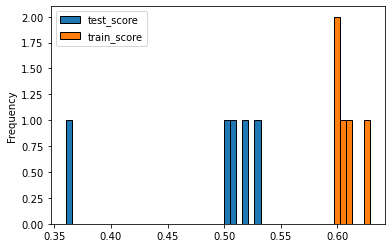

,test_score,train_score
0,0.665256,0.801218
1,0.758859,0.783016
2,0.741811,0.787542
3,0.697592,0.791190
4,0.731244,0.786660


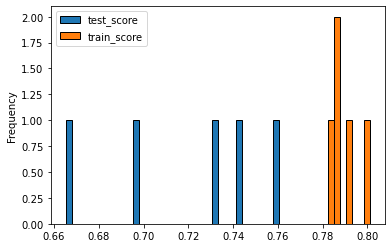

,test_score,train_score
0,0.075149,0.385207
1,0.065476,0.388255
2,0.056934,0.375732
3,0.056440,0.388097
4,0.065266,0.386132


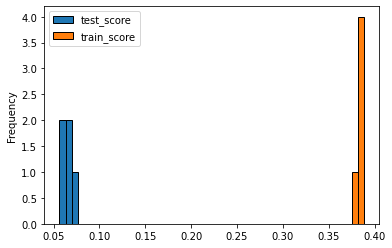

,test_score,train_score
0,0.160447,0.284613
1,0.154255,0.279379
2,0.231724,0.275631
3,0.145225,0.295711
4,0.150945,0.277437


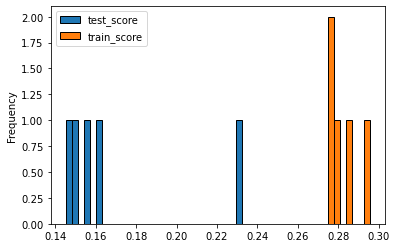

,Output,Mean R2,Std R2
0,"WHODAS_P,WHODAS_P_Total",0.483919,0.062492
1,"CIS_P,CIS_P_Score",0.718952,0.033483
2,"WHODAS_SR,WHODAS_SR_Score",0.063853,0.006856
3,"CIS_SR,CIS_SR_Total",0.168519,0.031984


In [92]:
# Check cross-validation performance of the final model on validation set for all models
def plot_test_vs_train_scores(cv_results):
    scores = pd.DataFrame(cv_results)[["test_score", "train_score"]]
    display(scores)
    scores.plot.hist(bins=50, edgecolor="black")
    plt.show()

results_val_set = []
for output in output_cols:
    estimator = best_estimators[output]
    cv_results = cross_validate(estimator, train_set[input_cols], train_set[output], return_train_score = True)
    metrics = [np.mean(cv_results["test_score"]), np.std(cv_results["test_score"])]
    results_val_set.append([
        output, 
        *metrics])
    
    plot_test_vs_train_scores(cv_results)
restults_val_set_df = pd.DataFrame(results_val_set, columns=["Output"] + ["Mean R2", "Std R2"])
restults_val_set_df

WHODAS_P,WHODAS_P_Total
r2:  0.4466444357305196


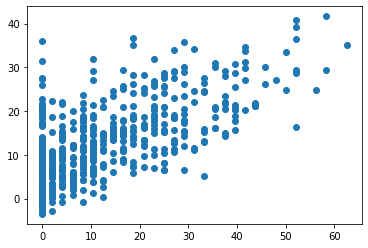

CIS_P,CIS_P_Score
r2:  0.7357646082127813


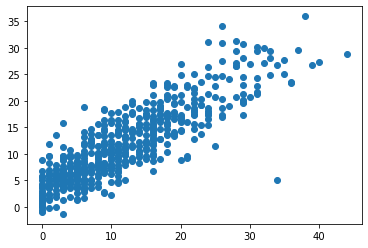

WHODAS_SR,WHODAS_SR_Score
r2:  0.05246660866808661


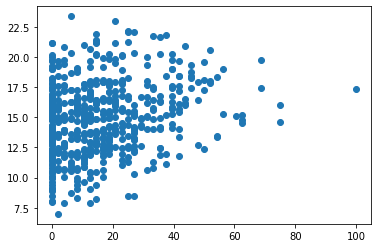

CIS_SR,CIS_SR_Total
r2:  0.20509237409641612


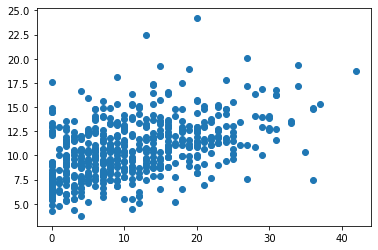

,Output,r2
1,"CIS_P,CIS_P_Score",0.735765
0,"WHODAS_P,WHODAS_P_Total",0.446644
3,"CIS_SR,CIS_SR_Total",0.205092
2,"WHODAS_SR,WHODAS_SR_Score",0.052467


In [93]:
# Check performance of the final model on test set for all models

results_test_set = []
for output in output_cols:
    estimator = best_estimators[output]
    metrics = get_metrics(estimator, output, input_cols, 'test', 1)
    results_test_set.append([
        output, 
        *metrics])
restults_test_set_df = pd.DataFrame(results_test_set, columns=["Output"] + metric_names)
restults_test_set_df.sort_values(by="r2", ascending=False)

### Feature importance

In [94]:
if IMPORTANCES_FROM_FILE == 1:
    forward_feature_objects = {}
    backward_feature_objects = {}
    try:
        forward_feature_objects = load('forward-sfs-imp-item-lvl.joblib')
    except Exception as e: print(e)

In [95]:
# Find elbow of the curve (draw a line from the first to the last point of the curve and then find the data point that is farthest away from that line) https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve 
def find_elbow(curve):
    from numpy import matlib 
    n_points = len(curve)
    all_coord = np.vstack((range(n_points), curve)).T
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)
    return idx_of_best_point + 1

def analyze_importances(importances):
    importances_list = []
    for key in importances:
        importances_list.append(importances[key]['avg_score'])
    importances_df = pd.DataFrame(importances_list, index=importances.keys(), columns=["r2"])
    display(importances_df)

    max_score = max(importances_list)
    n_cols_max_score = importances_df[importances_df["r2"] == max_score].index[0]
    print("Max score: ", max_score, " at ", n_cols_max_score, " features")
    features_up_to_max_score = importances[n_cols_max_score]["feature_names"]

    plt.figure(figsize=(16,8))
    plt.plot(importances_df)
    plt.xticks(np.arange(1,100, 3))
    plt.vlines(np.arange(1,100, 3), ymin=min(importances_list), ymax=max(importances_list), colors='purple', ls=':', lw=1)
    plt.show()
    
    optimal_nb_features = find_elbow(importances_list)
    print("Optimal number of features: ", optimal_nb_features)
    
    features_up_to_optimal = importances[optimal_nb_features]["feature_names"]
    display(features_up_to_optimal)
    
    return (features_up_to_optimal, features_up_to_max_score)

WHODAS_P,WHODAS_P_Total


,r2
1,0.174862
2,0.272092
3,0.331146
4,0.363643
5,0.387115
...,...
96,0.553514
97,0.553523
98,0.553528
99,0.553531


Max score:  0.5535311165293016  at  100  features


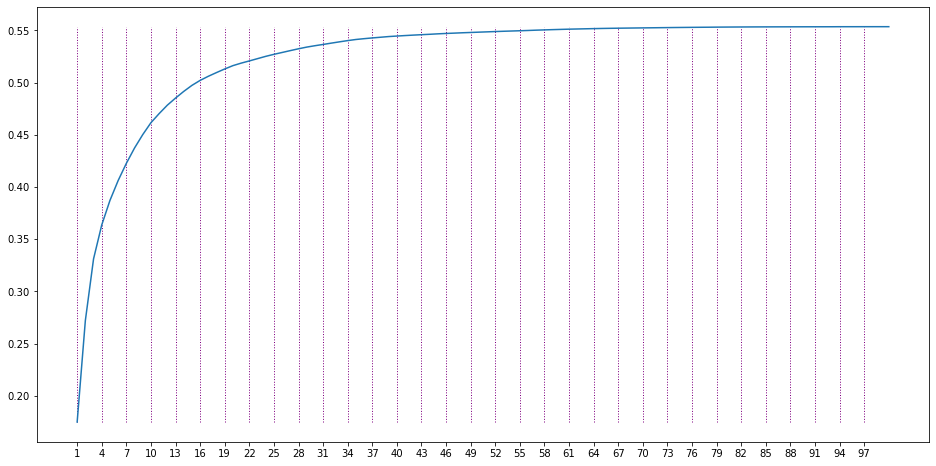

Optimal number of features:  17


('SympChck,CSC_18C',
 'ASSQ,ASSQ_24',
 'SDQ,SDQ_26',
 'SDQ,SDQ_29_b',
 'SRS,SRS_01',
 'SRS,SRS_34',
 'SRS,SRS_37',
 'SRS,SRS_44',
 'SRS,SRS_49',
 'CBCL,CBCL_04',
 'CBCL,CBCL_24',
 'CBCL,CBCL_62',
 'ESWAN,SocAnx_05',
 'MFQ_P,MFQ_P_06',
 'MFQ_P,MFQ_P_21',
 'PSI,PSI_21',
 'RBS,RBS_02')

CIS_P,CIS_P_Score


,r2
1,0.338756
2,0.469494
3,0.533616
4,0.568230
5,0.599893
...,...
96,0.756790
97,0.756813
98,0.756832
99,0.756850


Max score:  0.7568581814480574  at  100  features


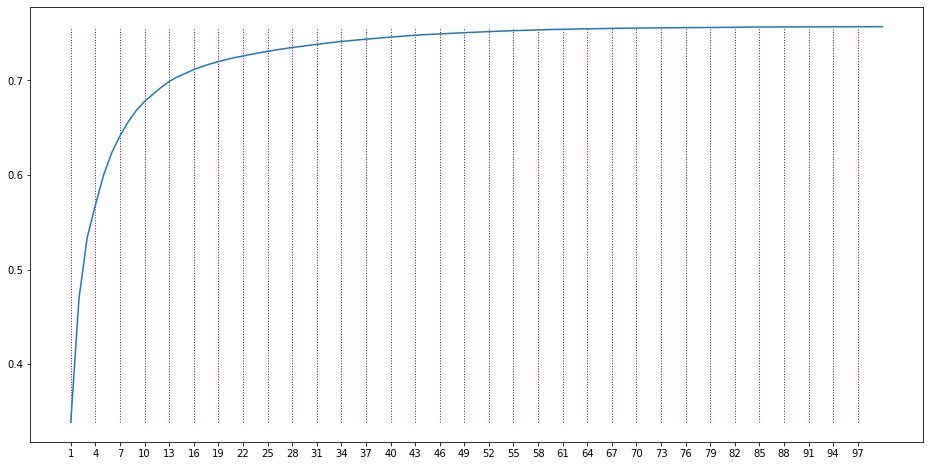

Optimal number of features:  14


('ASSQ,ASSQ_18',
 'ARI_P,ARI_P_01',
 'ARI_P,ARI_P_05',
 'SDQ,SDQ_12',
 'SDQ,SDQ_26',
 'SWAN,SWAN_04',
 'SRS,SRS_64',
 'CBCL,CBCL_103',
 'CBCL,CBCL_23',
 'CBCL,CBCL_50',
 'ICU_P,ICU_P_09',
 'PCIAT,PCIAT_18',
 'ESWAN,DMDD_10A',
 'PSI,PSI_35')

WHODAS_SR,WHODAS_SR_Score


,r2
1,0.023636
2,0.043493
3,0.052083
4,0.059822
5,0.062507
...,...
96,0.095107
97,0.096638
98,0.096086
99,0.095891


Max score:  0.10332448497746367  at  35  features


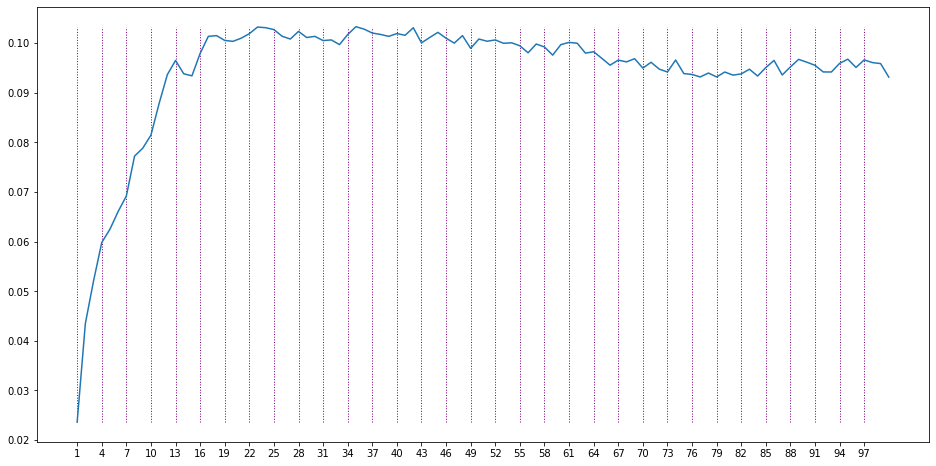

Optimal number of features:  17


('SympChck,CSC_08C',
 'SympChck,CSC_11C',
 'SympChck,CSC_55bC',
 'SDQ,SDQ_07',
 'SDQ,SDQ_23',
 'SRS,SRS_14',
 'SRS,SRS_36',
 'SRS,SRS_49',
 'CBCL,CBCL_12',
 'APQ_P,APQ_P_42',
 'PCIAT,PCIAT_16',
 'APQ_SR,APQ_SR_07A',
 'APQ_SR,APQ_SR_24',
 'APQ_SR,APQ_SR_34',
 'APQ_SR,APQ_SR_35',
 'APQ_SR,APQ_SR_39',
 'RBS,RBS_27')

CIS_SR,CIS_SR_Total


,r2
1,0.072888
2,0.100553
3,0.123440
4,0.139136
5,0.151987
...,...
96,0.207783
97,0.207783
98,0.207783
99,0.207783


Max score:  0.20778308057755132  at  99  features


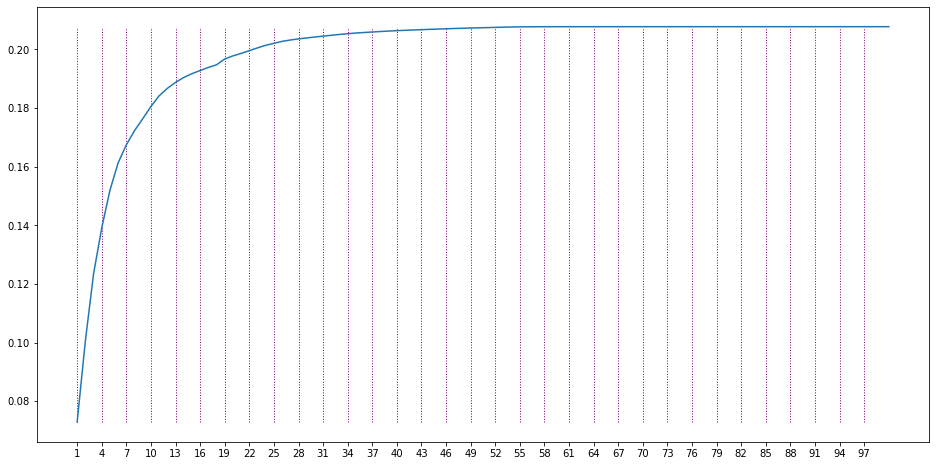

Optimal number of features:  14


('SympChck,CSC_47P',
 'SDQ,SDQ_13',
 'SDQ,SDQ_24',
 'CBCL,CBCL_23',
 'MFQ_P,MFQ_P_15',
 'MFQ_P,MFQ_P_29',
 'APQ_SR,APQ_SR_02',
 'APQ_SR,APQ_SR_07A',
 'APQ_SR,APQ_SR_12',
 'APQ_SR,APQ_SR_31',
 'APQ_SR,APQ_SR_33',
 'APQ_SR,APQ_SR_35',
 'APQ_SR,APQ_SR_37',
 'APQ_SR,APQ_SR_39')

In [96]:
from mlxtend.feature_selection import SequentialFeatureSelector

if IMPORTANCES_FROM_FILE == 0:
    forward_feature_subsets = {}
    forward_feature_objects = {}
    for output in output_cols:
        print(output)
        estimator = best_estimators[output]

        sfs = SequentialFeatureSelector(estimator, 
              k_features=100,
              forward=True, 
              scoring='r2',
              cv=3,
              n_jobs=-1)

        sfs = sfs.fit(train_set[input_cols], train_set[output])

        forward_feature_subsets[output] = sfs.subsets_
        forward_feature_objects[output] = sfs
        
        analyze_importances(forward_feature_objects[output].subsets_)

In [97]:
# Save importances to file
if IMPORTANCES_FROM_FILE == 0:
    dump(forward_feature_objects, 'forward-sfs-imp-item-lvl.joblib', compress=1)

WHODAS_P,WHODAS_P_Total


,r2
1,0.174862
2,0.272092
3,0.331146
4,0.363643
5,0.387115
...,...
96,0.553514
97,0.553523
98,0.553528
99,0.553531


Max score:  0.5535311165293016  at  100  features


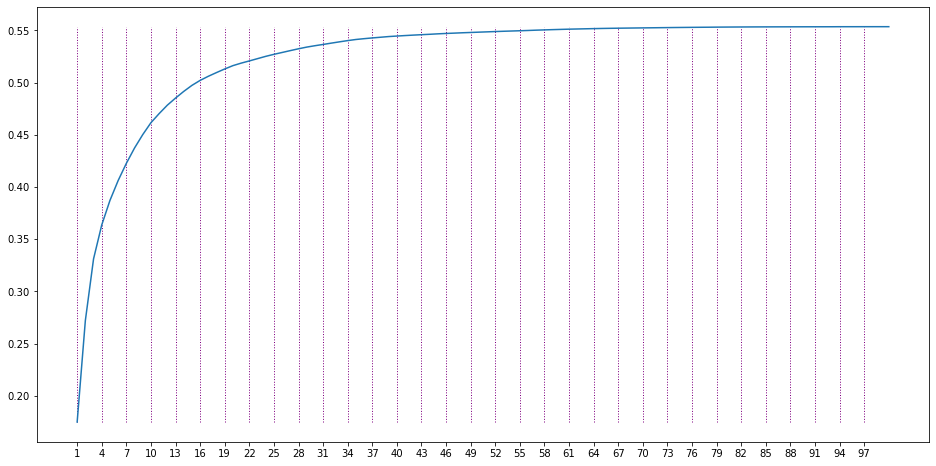

Optimal number of features:  17


('SympChck,CSC_18C',
 'ASSQ,ASSQ_24',
 'SDQ,SDQ_26',
 'SDQ,SDQ_29_b',
 'SRS,SRS_01',
 'SRS,SRS_34',
 'SRS,SRS_37',
 'SRS,SRS_44',
 'SRS,SRS_49',
 'CBCL,CBCL_04',
 'CBCL,CBCL_24',
 'CBCL,CBCL_62',
 'ESWAN,SocAnx_05',
 'MFQ_P,MFQ_P_06',
 'MFQ_P,MFQ_P_21',
 'PSI,PSI_21',
 'RBS,RBS_02')

Score using all features: 
WHODAS_P,WHODAS_P_Total
r2:  0.4466444357305196


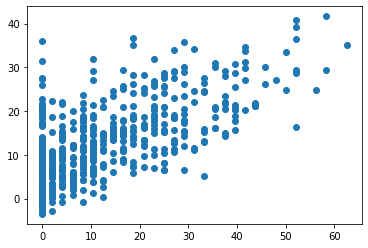

R2:  0.4466444357305196
Performance on test set using optimal number of columns: 
WHODAS_P,WHODAS_P_Total
r2:  0.38598990573196157


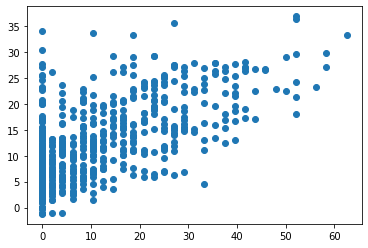

R2:  0.38598990573196157
Performance on test set using number of columns with maximum score
WHODAS_P,WHODAS_P_Total
r2:  0.4331502345933227


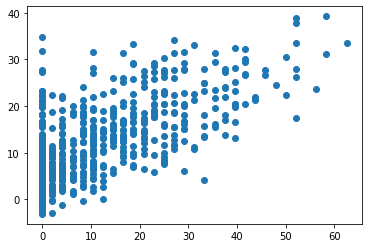

R2:  0.4331502345933227
CIS_P,CIS_P_Score


,r2
1,0.338756
2,0.469494
3,0.533616
4,0.568230
5,0.599893
...,...
96,0.756790
97,0.756813
98,0.756832
99,0.756850


Max score:  0.7568581814480574  at  100  features


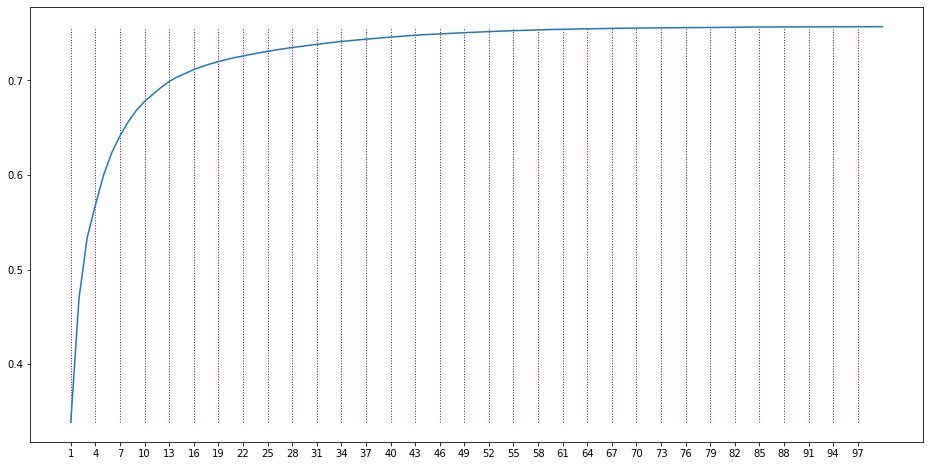

Optimal number of features:  14


('ASSQ,ASSQ_18',
 'ARI_P,ARI_P_01',
 'ARI_P,ARI_P_05',
 'SDQ,SDQ_12',
 'SDQ,SDQ_26',
 'SWAN,SWAN_04',
 'SRS,SRS_64',
 'CBCL,CBCL_103',
 'CBCL,CBCL_23',
 'CBCL,CBCL_50',
 'ICU_P,ICU_P_09',
 'PCIAT,PCIAT_18',
 'ESWAN,DMDD_10A',
 'PSI,PSI_35')

Score using all features: 
CIS_P,CIS_P_Score
r2:  0.7357646082127813


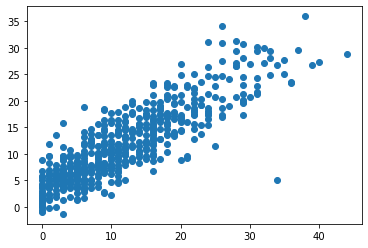

R2:  0.7357646082127813
Performance on test set using optimal number of columns: 
CIS_P,CIS_P_Score
r2:  0.6744560885355716


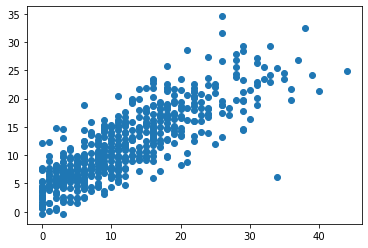

R2:  0.6744560885355716
Performance on test set using number of columns with maximum score
CIS_P,CIS_P_Score
r2:  0.7249476516843173


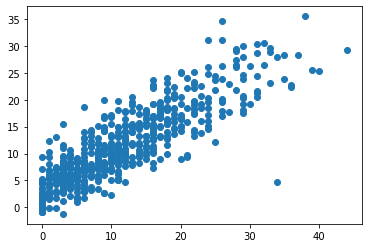

R2:  0.7249476516843173
WHODAS_SR,WHODAS_SR_Score


,r2
1,0.023636
2,0.043493
3,0.052083
4,0.059822
5,0.062507
...,...
96,0.095107
97,0.096638
98,0.096086
99,0.095891


Max score:  0.10332448497746367  at  35  features


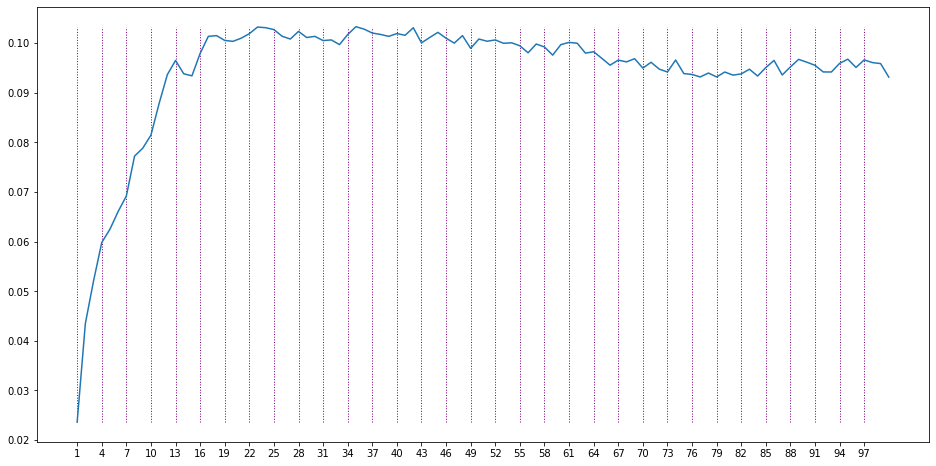

Optimal number of features:  17


('SympChck,CSC_08C',
 'SympChck,CSC_11C',
 'SympChck,CSC_55bC',
 'SDQ,SDQ_07',
 'SDQ,SDQ_23',
 'SRS,SRS_14',
 'SRS,SRS_36',
 'SRS,SRS_49',
 'CBCL,CBCL_12',
 'APQ_P,APQ_P_42',
 'PCIAT,PCIAT_16',
 'APQ_SR,APQ_SR_07A',
 'APQ_SR,APQ_SR_24',
 'APQ_SR,APQ_SR_34',
 'APQ_SR,APQ_SR_35',
 'APQ_SR,APQ_SR_39',
 'RBS,RBS_27')

Score using all features: 
WHODAS_SR,WHODAS_SR_Score
r2:  0.04457360327571691


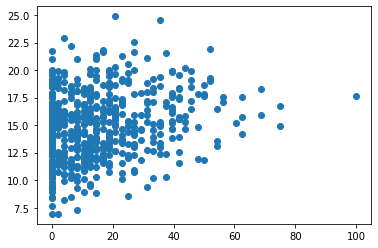

R2:  0.04457360327571691
Performance on test set using optimal number of columns: 
WHODAS_SR,WHODAS_SR_Score
r2:  0.06364462323898035


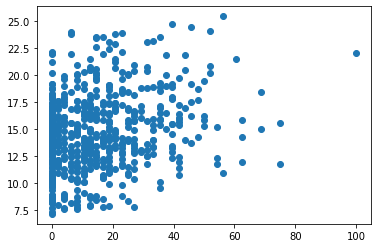

R2:  0.06364462323898035
Performance on test set using number of columns with maximum score
WHODAS_SR,WHODAS_SR_Score
r2:  0.05010386385592891


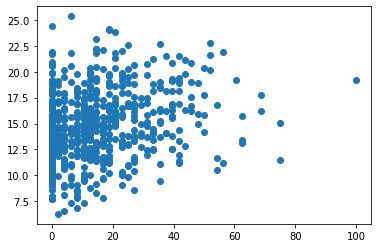

R2:  0.05010386385592891
CIS_SR,CIS_SR_Total


,r2
1,0.072888
2,0.100553
3,0.123440
4,0.139136
5,0.151987
...,...
96,0.207783
97,0.207783
98,0.207783
99,0.207783


Max score:  0.20778308057755132  at  99  features


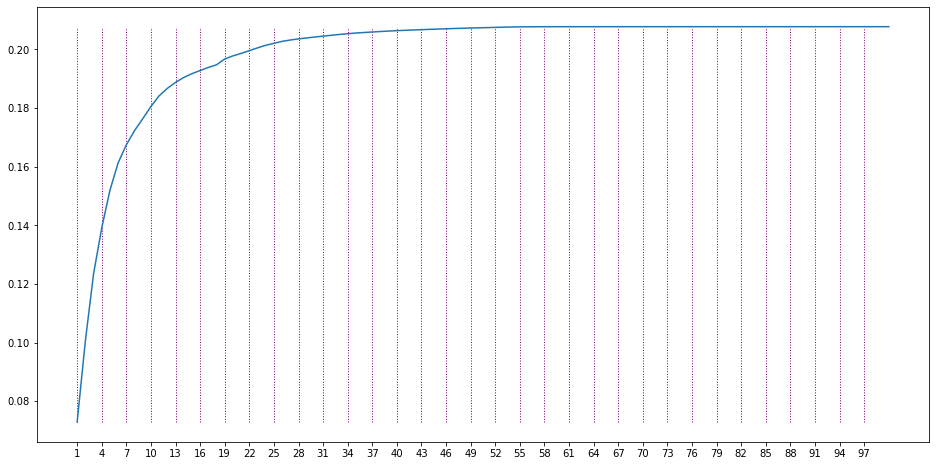

Optimal number of features:  14


('SympChck,CSC_47P',
 'SDQ,SDQ_13',
 'SDQ,SDQ_24',
 'CBCL,CBCL_23',
 'MFQ_P,MFQ_P_15',
 'MFQ_P,MFQ_P_29',
 'APQ_SR,APQ_SR_02',
 'APQ_SR,APQ_SR_07A',
 'APQ_SR,APQ_SR_12',
 'APQ_SR,APQ_SR_31',
 'APQ_SR,APQ_SR_33',
 'APQ_SR,APQ_SR_35',
 'APQ_SR,APQ_SR_37',
 'APQ_SR,APQ_SR_39')

Score using all features: 
CIS_SR,CIS_SR_Total
r2:  0.20509237409641612


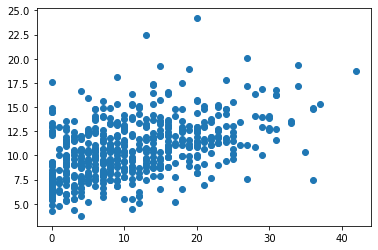

R2:  0.20509237409641612
Performance on test set using optimal number of columns: 
CIS_SR,CIS_SR_Total
r2:  0.18988594462889563


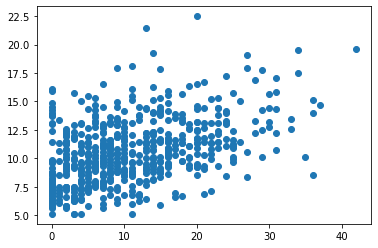

R2:  0.18988594462889563
Performance on test set using number of columns with maximum score
CIS_SR,CIS_SR_Total
r2:  0.2037429906732552


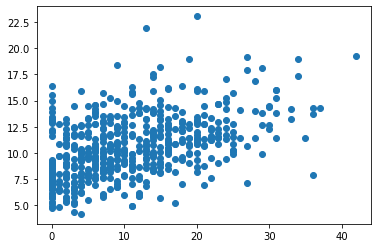

R2:  0.2037429906732552


In [98]:
# Print sfs results
for output in output_cols:
    print(output)
    
    features_up_to_optimal, features_up_to_max_score = analyze_importances(forward_feature_objects[output].subsets_)
    features_up_to_optimal = list(features_up_to_optimal)
    features_up_to_max_score = list(features_up_to_max_score)
    
    # Test both subsets on test set
    estimator = best_estimators[output]
    
    # All features
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[input_cols], train_set[output])
    print("Score using all features: ")
    metrics = get_metrics(new_estimator, output, input_cols, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])
    
    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_optimal], train_set[output])
    print("Performance on test set using optimal number of columns: ")
    metrics = get_metrics(new_estimator, output, features_up_to_optimal, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])

    # Create new pipeline with the same params (need to re-train the imputer on less features)
    new_estimator = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median'), StandardScaler(), estimator[2])
    new_estimator.fit(train_set[features_up_to_max_score], train_set[output])
    print("Performance on test set using number of columns with maximum score")
    metrics = get_metrics(new_estimator, output, features_up_to_max_score, 'test', 1)
    print("R2: ", metrics[metric_names.index("r2")])